# GW Data Access Demo

This notebook shows how to load and use the processed gravitational wave data for machine learning.

## Data Overview
- `processed_data/signals/` - GW signals (BBH, BNS)
- `processed_data/glitches/` - Detector glitches (Blip, Whistle, etc.)
- Each folder has: metadata.csv, features.csv, *_processed.npy, *_spectrogram.npz

In [ ]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

print("Ready to load GW data!")

Libraries imported successfully!
Current working directory: /Users/rahulgupta/STG/GW-Signal-Classification


## 1. Load Data

First, let's load the metadata and feature files to understand what data we have available.

In [ ]:
# Define data paths
processed_data_path = "processed_data"
splits = ['train', 'validation', 'test']
data_types = ['signals', 'glitches']

# Load all metadata and features
def load_data():
    all_metadata, all_features = [], []
    
    for split in ['train', 'validation', 'test']:
        for dtype in ['signals', 'glitches']:
            dir_path = f"processed_data/{dtype}/{split}"
            if not os.path.exists(dir_path):
                continue
                
            # Load metadata
            meta_file = f"{dir_path}/metadata.csv"
            if os.path.exists(meta_file):
                df = pd.read_csv(meta_file)
                df['split'] = split
                df['data_type'] = dtype
                all_metadata.append(df)
            
            # Load features
            feat_file = f"{dir_path}/features.csv"
            if os.path.exists(feat_file):
                df = pd.read_csv(feat_file)
                df['split'] = split
                df['data_type'] = dtype
                all_features.append(df)
    
    metadata_df = pd.concat(all_metadata, ignore_index=True) if all_metadata else pd.DataFrame()
    features_df = pd.concat(all_features, ignore_index=True) if all_features else pd.DataFrame()
    
    return metadata_df, features_df

# Load the data
print("Loading metadata and features...")
metadata_df, features_df = load_data()

print(f"\nTotal metadata entries: {len(metadata_df)}")
print(f"Total feature entries: {len(features_df)}")

# Display basic info
if not metadata_df.empty:
    print("\nMetadata columns:", list(metadata_df.columns))
if not features_df.empty:
    print("Features columns:", list(features_df.columns))

Loading metadata and features...
Loaded 141 metadata entries from train/signals
Loaded 141 feature entries from train/signals
Loaded 946 metadata entries from train/glitches
Loaded 946 feature entries from train/glitches
Loaded 17 metadata entries from validation/signals
Loaded 17 feature entries from validation/signals
Loaded 32 metadata entries from validation/glitches
Loaded 32 feature entries from validation/glitches
Loaded 15 metadata entries from test/signals
Loaded 15 feature entries from test/signals
Loaded 33 metadata entries from test/glitches
Loaded 33 feature entries from test/glitches

Total metadata entries: 1184
Total feature entries: 1184

Metadata columns: ['filename', 'original_duration', 'original_sample_rate', 'processed_sample_rate', 'duration', 'signal_type', 'class', 'split', 'data_type']
Features columns: ['mean', 'std', 'var', 'skewness', 'kurtosis', 'rms', 'peak_to_peak', 'zero_crossings', 'dominant_freq', 'spectral_centroid', 'spectral_spread', 'spectral_roll

## Quick Overview

=== METADATA EXPLORATION ===

Dataset Summary:
                filename  original_duration  original_sample_rate  \
0  BBH_H1_1239917954.gwf               32.0                4096.0   
1  BBH_H1_1256779567.gwf               32.0                4096.0   
2  BBH_L1_1135136350.gwf               32.0                4096.0   
3  BBH_L1_1253885759.gwf               32.0                4096.0   
4  BBH_H1_1187058327.gwf               32.0                4096.0   

   processed_sample_rate  duration signal_type   class  split data_type  
0                 2048.0      32.0         BBH  signal  train   signals  
1                 2048.0      32.0         BBH  signal  train   signals  
2                 2048.0      32.0         BBH  signal  train   signals  
3                 2048.0      32.0         BBH  signal  train   signals  
4                 2048.0      32.0         BBH  signal  train   signals  

Class Distribution:
class
glitch    1011
signal     173
Name: count, dtype: int64

Signal Typ

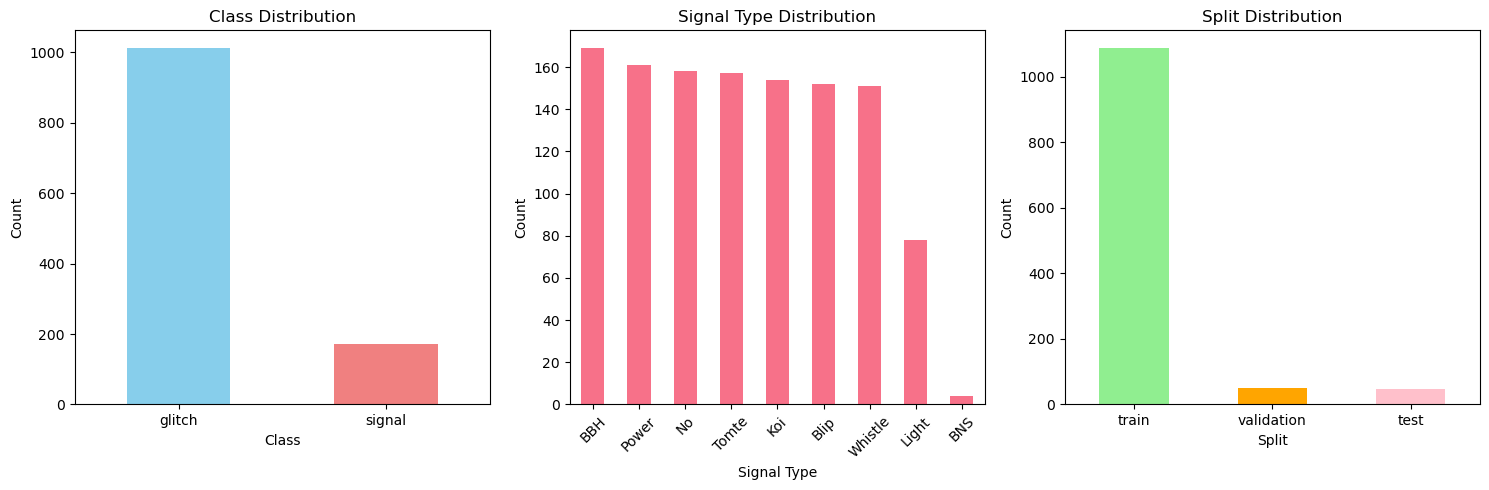


=== FEATURES EXPLORATION ===

Feature dataset shape: (1184, 21)
Number of numerical features: 16
Feature names: ['mean', 'std', 'var', 'skewness', 'kurtosis', 'rms', 'peak_to_peak', 'zero_crossings', 'dominant_freq', 'spectral_centroid'] ...

Basic Statistics:
              mean         std           var   skewness   kurtosis  \
count    1165.0000   1165.0000  1.165000e+03  1165.0000  1165.0000   
mean      -78.8975    147.8346  2.338885e+06     0.1023     3.8452   
std      6608.4489   1522.8329  6.364398e+07     2.0654    10.0502   
min   -198311.1630      1.2673  1.606100e+00    -5.1945    -0.5884   
25%       -45.0933     27.8626  7.763272e+02    -0.9725    -0.2907   
50%        -8.7524     38.5206  1.483838e+03     0.8134    -0.2877   
75%        43.9188     65.7545  4.323655e+03     0.9729    -0.2602   
max    102658.5917  45812.6426  2.098798e+09     5.8215    88.6206   

               rms  peak_to_peak  zero_crossings  dominant_freq  \
count    1165.0000     1165.0000       1

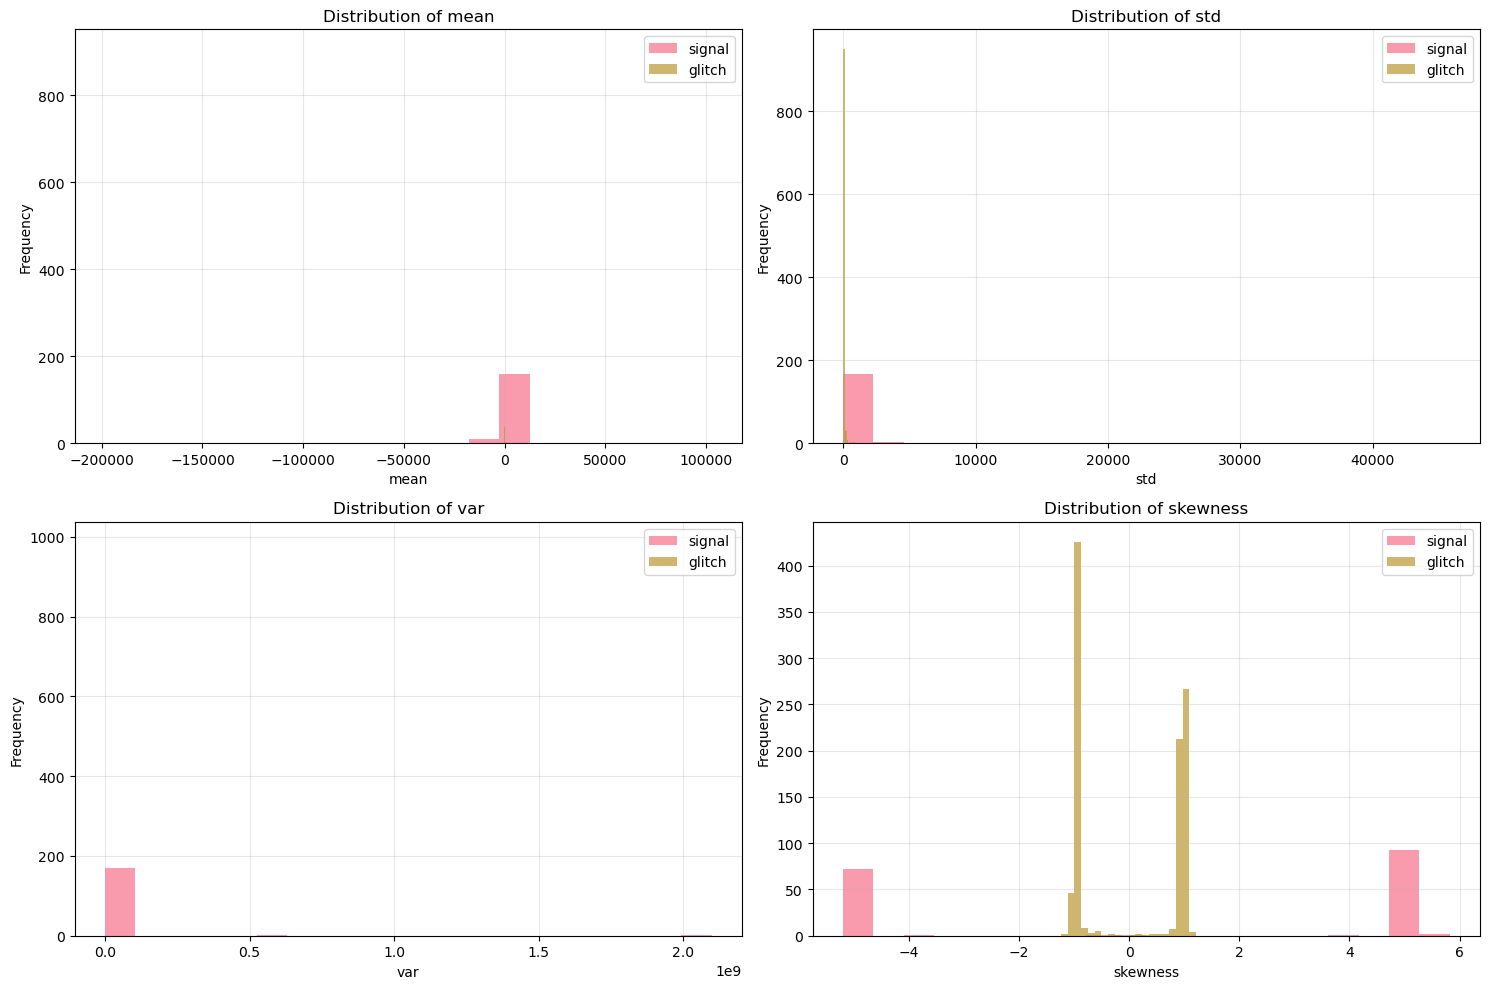

In [ ]:
# Show data summary
if not metadata_df.empty:
    print("Class distribution:")
    print(metadata_df['class'].value_counts())
    print("\nSignal types:")
    print(metadata_df['signal_type'].value_counts())
    
    # Simple plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    metadata_df['class'].value_counts().plot(kind='bar', ax=ax1, title='Classes')
    metadata_df['signal_type'].value_counts().plot(kind='bar', ax=ax2, title='Signal Types')
    plt.tight_layout()
    plt.show()

if not features_df.empty:
    feature_cols = [col for col in features_df.columns 
                   if col not in ['filename', 'class', 'signal_type', 'split', 'data_type']]
    print(f"\nAvailable features ({len(feature_cols)}): {feature_cols[:5]}...")

## Load Sample Data

Now let's load some sample processed time series data (.npy files) and link them to the metadata.

In [ ]:
# Function to find and load time series data files
def find_timeseries_files():
    """Find all processed time series .npy files"""
    timeseries_files = []
    
    for split in splits:
        for data_type in data_types:
            dir_path = os.path.join(processed_data_path, data_type, split)
            if os.path.exists(dir_path):
                pattern = os.path.join(dir_path, "*_processed.npy")
                files = glob.glob(pattern)
                for file in files:
                    timeseries_files.append({
                        'filepath': file,
                        'filename': os.path.basename(file),
                        'split': split,
                        'data_type': data_type,
                        'original_filename': os.path.basename(file).replace('_processed.npy', '.gwf')
                    })
    
    return timeseries_files

# Find all time series files
timeseries_files = find_timeseries_files()
print(f"Found {len(timeseries_files)} processed time series files")

if timeseries_files:
    # Show sample of available files
    print("\nSample of available files:")
    for i, file_info in enumerate(timeseries_files[:5]):
        print(f"  {i+1}. {file_info['filename']} ({file_info['split']}/{file_info['data_type']})")
    
    # Load sample time series and spectrograms
    sample_data = {}

    # Find files
    for dtype in ['signals', 'glitches']:
        for split in ['train']:
            dir_path = f"processed_data/{dtype}/{split}"
            if os.path.exists(dir_path):
                npy_files = glob.glob(f"{dir_path}/*_processed.npy")
                npz_files = glob.glob(f"{dir_path}/*_spectrogram.npz")
                
                if npy_files and npz_files:
                    # Load first available file from each type
                    class_name = 'signal' if dtype == 'signals' else 'glitch'
                    
                    # Time series
                    ts_data = np.load(npy_files[0])
                    sample_data[f'{class_name}_ts'] = ts_data
                    
                    # Spectrogram
                    spec_data = np.load(npz_files[0])
                    sample_data[f'{class_name}_spec'] = {
                        'power': spec_data['power'],
                        'frequencies': spec_data['frequencies'],
                        'times': spec_data['times']
                    }
                    
                    print(f"Loaded {class_name}: TS shape {ts_data.shape}, Spec shape {spec_data['power'].shape}")
                    break

    print(f"Loaded {len(sample_data)} sample datasets")
else:
    print("No time series files found. Make sure the preprocessing has been run.")

Found 1184 processed time series files

Sample of available files:
  1. BBH_L1_1260484270_processed.npy (train/signals)
  2. BBH_L1_1258866165_processed.npy (train/signals)
  3. BBH_H1_1266214786_processed.npy (train/signals)
  4. BBH_L1_1266140673_processed.npy (train/signals)
  5. BBH_H1_1128678900_processed.npy (train/signals)

Loaded signal example:
  File: BBH_L1_1260484270_processed.npy
  Shape: (65536,)
  Duration: 32.00 seconds (assuming 2048 Hz)
  Data range: [-7.00e+02, 2.15e+03]

Loaded glitch example:
  File: Blip_L1_1263090972_processed.npy
  Shape: (8192,)
  Duration: 4.00 seconds (assuming 2048 Hz)
  Data range: [-5.99e+01, 2.42e+01]

Successfully loaded 2 sample time series


## Baseline Models (Features)

Let's prepare the extracted features for training baseline classifiers like logistic regression and random forest.

In [7]:
# Prepare features for baseline models
if not features_df.empty:
    # Get feature columns
    feature_cols = [col for col in features_df.columns 
                   if col not in ['filename', 'class', 'signal_type', 'split', 'data_type']]
    
    # Prepare data
    X = features_df[feature_cols].values
    y = features_df['class'].values
    X = np.nan_to_num(X)  # Handle missing values
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Use train/test splits if available
    train_mask = features_df['split'] == 'train'
    test_mask = features_df['split'] == 'test'
    
    if train_mask.any() and test_mask.any():
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y_encoded[train_mask], y_encoded[test_mask]
        
        # Train a simple model
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        train_acc = model.score(X_train_scaled, y_train)
        test_acc = model.score(X_test_scaled, y_test)
        
        print(f"Random Forest Results:")
        print(f"  Features: {len(feature_cols)}")
        print(f"  Train accuracy: {train_acc:.3f}")
        print(f"  Test accuracy: {test_acc:.3f}")
        
        # Show top features
        importance = model.feature_importances_
        top_idx = np.argsort(importance)[-5:][::-1]
        print(f"  Top features: {[feature_cols[i] for i in top_idx]}")
else:
    print("No features available")

=== PREPARING DATA FOR BASELINE MODELS ===
Feature matrix shape: (1184, 16)
Number of samples: 1184
Number of features: 16
Classes: ['glitch' 'signal']
Label encoding: {'glitch': 0, 'signal': 1}
Using predefined splits:
  Train: 1087 samples
  Validation: 49 samples
  Test: 48 samples
\nFeatures standardized using StandardScaler
\n=== TRAINING BASELINE MODELS ===
\nTraining Logistic Regression...
  Validation accuracy: 1.000
\nTraining Random Forest...
  Validation accuracy: 0.980
  Top 10 important features:
    1. kurtosis: 0.3704
    2. skewness: 0.1452
    3. zero_crossings: 0.1283
    4. rms: 0.0967
    5. peak_to_peak: 0.0685
    6. energy_mid_band: 0.0471
    7. energy_high_band: 0.0358
    8. mean: 0.0262
    9. energy_low_band: 0.0211
    10. spectral_spread: 0.0158
\n=== USAGE EXAMPLE ===
# To load data for your baseline models:
X_train, y_train_enc, y_train_orig = prepare_baseline_data('train')
X_val, y_val_enc, y_val_orig = prepare_baseline_data('validation')
X_test, y_test